In [1]:
#mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Notebooks/


/content/gdrive/MyDrive/Notebooks


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import pickle
import seaborn as sns
from tqdm import tqdm
import os

In [2]:
df = pd.read_csv('processed_df.csv')
#one row is empty.we will drop it
df = df.dropna(axis=0)
# #sampling 100k points 
df = df.sample(100000,random_state=100)
#sortimg based on time
df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)



In [3]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = df['clean_text']
y = df['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)
X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)

## Bag of words

In [4]:
bow = CountVectorizer()
bow.fit(X_tr)
X_train_bow = bow.transform(X_tr)
X_cv_bow = bow.transform(X_cv)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_cv_bow is {}'.format(X_cv_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (49000, 43086)
shape of X_cv_bow is (21000, 43086)
shape of X_test_bow is (30000, 43086)


# TFIDF

In [5]:
#applying bow on x_train and x_test
vectorizer = TfidfVectorizer()
vectorizer.fit(X_tr)
tfidf_features = vectorizer.get_feature_names()
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_tr)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

#Word2Vec

In [6]:
preprocessed_reviews = X_tr.values
train_sentence = [rev.split() for rev in preprocessed_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model_train = Word2Vec(train_sentence,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model_train.wv.vocab)

## AvgWord2Vec

In [7]:
train_reviews = X_tr.values
train_sentence = [rev.split() for rev in train_reviews]

sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

########################################################

cv_reviews = X_cv.values
cv_sentence = [rev.split() for rev in cv_reviews]

sent_vectors_cv = []
for sent in tqdm(cv_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1
            
    if count != 0:
        sent_vec /= count
    sent_vectors_cv.append(sent_vec)

print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

########################################################
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]

sent_vectors_test = []
for sent in tqdm(test_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1
            
    if count != 0:
        sent_vec /= count
    sent_vectors_test.append(sent_vec)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [01:18<00:00, 624.33it/s]


49000
50


100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:33<00:00, 621.79it/s]


21000
50


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:48<00:00, 620.96it/s]

30000
50


## TFIDF Word2Vec

In [8]:
tfidf = TfidfVectorizer()
tfidf.fit(X_tr)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

train_reviews = X_tr.values
train_sentence = [rev.split() for rev in train_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(sent_vectors_train[0])


100%|████████████████████████████████████████████████████████████████████████████| 49000/49000 [16:43<00:00, 48.85it/s]

49000
[-1.55825669 -0.35529014  0.86537362  0.58127055 -0.36973246 -0.62067076
 -0.04746119 -1.26524101 -0.5398465  -0.7970504  -0.66625128  1.18075244
 -1.02974119 -0.44524866 -0.39376018 -1.72988441 -1.52497473  0.26617613
 -1.48040046  1.10566325  1.10145614  2.07295973  0.35891277  0.50296094
 -0.43758117 -0.8725804  -0.48639766 -1.70937891  0.47980756  1.43419112
 -0.81725744  0.09494249 -0.58746173 -0.23870876 -1.38720916  1.90244862
 -0.32916643  1.14942878  0.57196601 -0.25193329 -0.95679104 -0.94972109
  0.20456823 -1.32523    -0.2926762  -1.0180857   1.77061126  0.10636948
  1.54405271  0.02340289]


In [9]:
cv_reviews = X_cv.values
cv_sentence = [rev.split() for rev in cv_reviews]
sent_vectors_cv = []
for sent in tqdm(cv_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(sent_vectors_cv[0])   

###############################################

test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]
sent_vectors_test = []
for sent in tqdm(test_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(sent_vectors_test[0])   

100%|████████████████████████████████████████████████████████████████████████████| 21000/21000 [06:28<00:00, 53.99it/s]


21000
[-1.04559737  0.60644091  0.1089876  -1.19240335 -0.29175345  0.51334009
 -0.72670826  0.68344916  0.66162768  0.23507735 -0.95268741  0.17309111
  0.00589341 -0.20348125  0.66661039 -0.60642519  0.37436512 -0.14550496
 -0.5777665   0.44261109  0.00474718  0.30704668  0.87934666  0.76469747
 -0.54531037  0.26720433 -0.69530859  0.43475254  0.12080326 -1.04563036
  1.40752807 -0.08655924 -0.85540447  1.41871168  0.74212978  0.41641158
  0.45767156  0.82242668 -0.18880918 -0.07272902 -0.46533849 -0.20609635
 -0.66602485  0.50405307  1.66376663 -0.01905803 -0.36598468 -0.81928091
 -0.48280359  0.70159318]


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [09:52<00:00, 50.63it/s]

30000
[ 0.33551728 -0.0339503   0.54574551  0.18539578  0.45548078  0.23559941
  0.04104288  0.38177511  0.42521721  0.26923846  0.069368   -0.57887351
 -0.11086136  0.24885409  0.24451498 -0.45886632 -0.09032865 -0.21735664
 -0.87025633  0.21896334  0.27482783  0.02089392  0.36656552  0.69213675
  0.85772157 -0.25323022 -0.06914865  0.01996259  0.35158086  0.00889495
  0.28726104 -0.56510921 -0.57172816 -0.20755423  0.08045389  0.34041872
  0.02754974  0.43995994  0.23895672 -0.10420459 -0.59206917 -0.76155744
 -0.15682886  0.47176913  0.05090478  0.24377141  0.26601633 -0.60154763
  0.09929887  0.38564639]


In [10]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

# Naive Bayes

## Naive Bayes On BagOfWords Features 

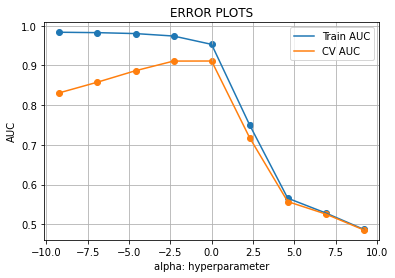

In [11]:
train_auc = []
cv_auc = []
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for param in alpha:
    naive = MultinomialNB(alpha=param)
    naive.fit(X_train_bow,y_tr)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    y_train_pred =  naive.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  naive.predict_proba(X_cv_bow)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
#plotting
plt.grid(True)
plt.plot(np.log(alpha), train_auc, label='Train AUC')
plt.plot(np.log(alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(alpha), train_auc)
plt.scatter(np.log(alpha), cv_auc)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

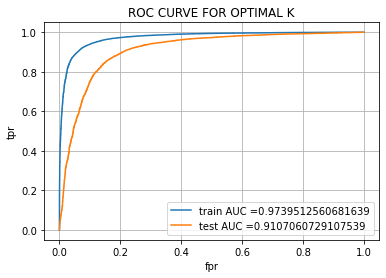

Area under train roc 0.9739512560681639
Area under test roc 0.9107060729107539


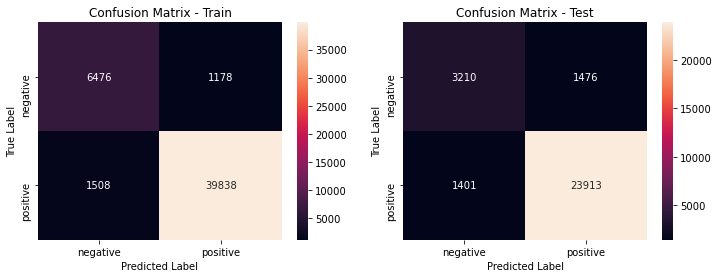

In [12]:
from sklearn.metrics import roc_curve, auc
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, naive_opt.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(naive_opt,X_train_bow,y_tr,X_test_bow,y_test)

### Feature importance

In [13]:
data_l = naive_opt.coef_.reshape(-1,1)
features = bow_features
datafr_l = pd.DataFrame(data_l,columns=['coef'],index=features)
#Top 10 negative features
negative = datafr_l.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                        coef
maybeif          -16.588911
metformin        -16.588911
choffy           -16.588911
chocolite        -16.588911
chocolatre       -16.588911
chocolatl        -16.588911
chocolatestevita -16.588911
sorgham          -16.588911
chocoerfection   -16.588911
mezetta          -16.588911
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
              coef
not     -3.731187
like    -4.558436
good    -4.670113
great   -4.750567
one     -4.912838
taste   -4.969906
product -5.064343
coffee  -5.072581
flavor  -5.082496
would   -5.101703


# Naive Bayes On TFIDF Features

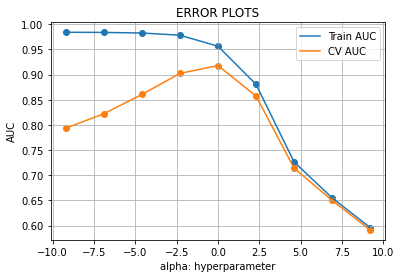

In [14]:
train_auc = []
cv_auc = []
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for param in alpha:
    naive = MultinomialNB(alpha=param)
    naive.fit(X_train_bow,y_tr)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    y_train_pred =  naive.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  naive.predict_proba(X_cv_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
#plotting
plt.grid(True)
plt.plot(np.log(alpha), train_auc, label='Train AUC')
plt.plot(np.log(alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(alpha), train_auc)
plt.scatter(np.log(alpha), cv_auc)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

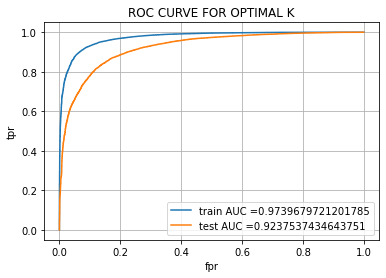

Area under train roc 0.9739679721201785
Area under test roc 0.9237537434643751


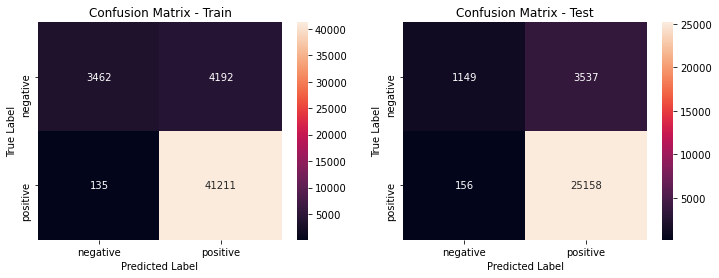

In [15]:
from sklearn.metrics import roc_curve, auc
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, naive_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

plot_confusion_matrixes(naive_opt,X_train_tfidf,y_tr,X_test_tfidf,y_test)

### Feature importance

In [16]:
data_l = naive_opt.coef_.reshape(-1,1)
features = tfidf_features
datafr_l = pd.DataFrame(data_l,columns=['coef'],index=features)
#Top 10 negative features
negative = datafr_l.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                        coef
cyanide          -14.530479
hadnt            -14.530479
hackleback       -14.530479
oatfit           -14.530479
hacked           -14.530479
environmentalism -14.530479
environmentalist -14.530479
envisioning      -14.530479
habitant         -14.530479
bauli            -14.530479
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
              coef
not     -4.876303
great   -5.180446
good    -5.261669
like    -5.343107
coffee  -5.384229
love    -5.438336
tea     -5.441488
product -5.528185
taste   -5.554512
flavor  -5.592877


## Observations and Conclusions


* We tried out multinomial naive bayes here with bow and tfidf features we tried earlier.
* Even after hyperparamter tuning both models are slightly overfitting.
* Tfidf features model performed slightly better.
* We also able to find out most important features contributing to each model
* Naive bayes can be considered as a baseline model for our problem

In [17]:
from prettytable import PrettyTable
    
z = PrettyTable()
z.field_names = ["Vector","Algorithm","Hyperparameter-alpha", "Train AUC", "Test AUC"]
z.add_row(["bow","naive-bayes",0.1,0.9861029705576311, 0.9362621984059971])
z.add_row(["tfidf","naive-bayes",0.1,0.9850954607767481,0.9422741199475984])
print(z)


+--------+-------------+----------------------+--------------------+--------------------+
| Vector |  Algorithm  | Hyperparameter-alpha |     Train AUC      |      Test AUC      |
+--------+-------------+----------------------+--------------------+--------------------+
|  bow   | naive-bayes |         0.1          | 0.9861029705576311 | 0.9362621984059971 |
| tfidf  | naive-bayes |         0.1          | 0.9850954607767481 | 0.9422741199475984 |
+--------+-------------+----------------------+--------------------+--------------------+
